In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import scanpy.external as sce
import sklearn.manifold
import statsmodels.api as sm

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyclustering.cluster.kmedoids import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn as sb

import scanpy as sc
import harmonypy as hm
import anndata
import pickle
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import chi2_contingency
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 
import os
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
from _util_updated import cluster_bias

### Load Data

In [2]:
SC_DF = sc.read_h5ad('./Knockout_SC_DF.h5ad')

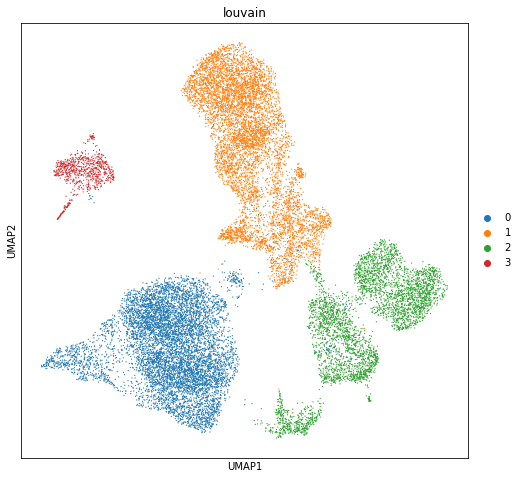

In [3]:
sc.pl.umap(SC_DF, color = 'louvain')

### Cluster Defining Gene CSV

In [9]:
cluster_id = ['Endoderm', 'Cardiomyoctes', 'Neuronal', 'Other']
cluster_dict = dict(zip(SC_DF.obs.louvain.cat.categories, cluster_id))

In [10]:
Cluster = '0'
Pos_Genes = SC_DF.uns['rank_genes_groups']['names'][Cluster][SC_DF.uns['rank_genes_groups']['scores'][Cluster] > 0]
Pval_Genes = SC_DF.uns['rank_genes_groups']['names'][Cluster][SC_DF.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]

Pvals = []
for gene in Pos_Genes[0:100]:
    pval_pos = np.argwhere(SC_DF.uns['rank_genes_groups']['names'][Cluster] == gene)[0][0]
    if SC_DF.uns['rank_genes_groups']['pvals'][Cluster][pval_pos] == 0:
        Pvals.append(2.225e-308)
    else:
        Pvals.append(SC_DF.uns['rank_genes_groups']['pvals'][Cluster][pval_pos])

Cluster_Gene_DF = pd.DataFrame(data=Pos_Genes[0:100], columns=[cluster_dict[str(Cluster)] + '_genes'])
Cluster_Gene_DF[cluster_dict[str(Cluster)] + '_pvals']  = Pvals

In [11]:
for cluster in SC_DF.obs.louvain.cat.categories:
    if cluster == 0:
        continue
    
    Pos_Genes = SC_DF.uns['rank_genes_groups']['names'][cluster][SC_DF.uns['rank_genes_groups']['scores'][Cluster] > 0]
    Pval_Genes = SC_DF.uns['rank_genes_groups']['names'][cluster][SC_DF.uns['rank_genes_groups']['pvals_adj'][Cluster] < 0.05]
    Sig_Genes = [i for i in Pval_Genes if i in Pos_Genes]
    
    Pvals = []
    for gene in Pos_Genes[0:100]:
        pval_pos = np.argwhere(SC_DF.uns['rank_genes_groups']['names'][cluster] == gene)[0][0]
        if SC_DF.uns['rank_genes_groups']['pvals'][cluster][pval_pos] == 0:
            Pvals.append(2.225e-308)
        else:
            Pvals.append(SC_DF.uns['rank_genes_groups']['pvals'][cluster][pval_pos])
    Cluster_Gene_DF[cluster_dict[str(cluster)] + '_genes'] = Pos_Genes[0:100]
    Cluster_Gene_DF[cluster_dict[str(cluster)] + '_pvals'] = Pvals

In [12]:
Cluster_Gene_DF.to_csv('KO_Screen_All_ClusterGenes.csv')

### Cluster Bias (Combined Biological Reps)

In [13]:
control_cells = SC_DF[SC_DF.obs.Sample == 'WT'].obs.index.tolist()

In [14]:
Enr_List = []
Depleted_List = []
Target_List = []

for sample in SC_DF.obs.Sample.cat.categories.tolist():
    if sample == 'WT':
        continue
    Target_List.append(sample)
    target_cells = SC_DF[SC_DF.obs.Sample == sample].obs.index.tolist()
    
    depleted_pvals, depleted_list = cluster_bias(target_cells,control_cells, SC_DF, direction='depletion')
    enriched_pvals, enriched_list = cluster_bias(target_cells,control_cells, SC_DF, direction='enrichment')
    
    Enr_List.append(enriched_pvals)
    Depleted_List.append(depleted_pvals)

In [15]:
Enr_DF = pd.DataFrame(data=Enr_List, columns=SC_DF.obs.louvain.cat.categories.tolist(), index = Target_List)
Dep_DF = pd.DataFrame(data=Depleted_List, columns=SC_DF.obs.louvain.cat.categories.tolist(), index = Target_List)

In [27]:
Dep_DF

,0,1,2,3
ENH3,1.0,3.155272e-201,0.0,1.0
ENH5,1.0,5.157903e-125,0.0,1.0


### Bar Graph Distribution

In [17]:
cluster_list = ['1']

In [26]:
Total_Percents = []
Targets = []
for target in SC_DF.obs.Sample.cat.categories:
    Targets.append(target)
    
    target_sc = SC_DF[SC_DF.obs['Sample'] == target]
    target_cells = target_sc.shape[0]
    target_percents = []
    
    for cluster in cluster_list:
        target_percents.append((target_sc[target_sc.obs.louvain == cluster].shape[0]/target_cells)*100)
        
    Total_Percents.append(target_percents)

In [19]:
ENH3_cmap = {
    'CM': '#dd8452'}

In [20]:
ENH5_cmap = {
    'CM': '#C4B04F'}

In [22]:
WT_cmap = {
    'CM': '#8c8c8c'}

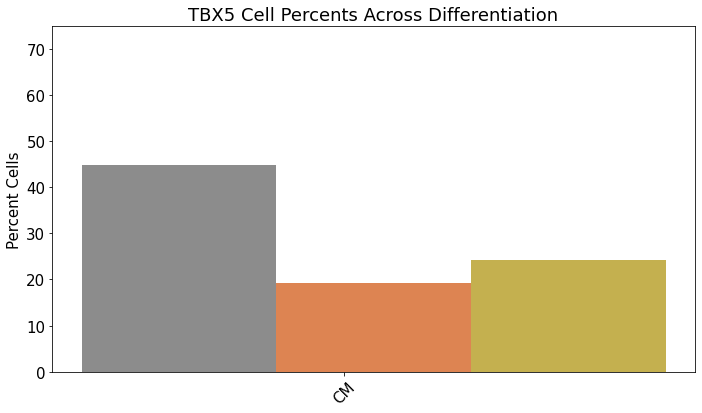

In [25]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, figsize=(10,6))

width = 0.20

labels =  ['CM' ]


for i, c in enumerate(Total_Percents[2]):
    ax.bar(i, c, width, color=WT_cmap[labels[i]])
    
for i, c in enumerate(Total_Percents[0]):
    ax.bar(i + width, c, width, color=ENH3_cmap[labels[i]])

for i, c in enumerate(Total_Percents[1]):
    ax.bar(i + width + width, c, width, color=ENH5_cmap[labels[i]])
    
ax.set_xticks(np.arange(i+1) + .17)
ax.set_xticklabels(labels)
ax.set_ylabel('% Cells')
plt.xticks(rotation = 45)
rects = ax.patches
rect_subset = rects[4:]



plt.ylim(0, 75)
plt.ylabel('Percent Cells')
plt.title('TBX5 Cell Percents Across Differentiation')
fig.tight_layout()
fig.savefig('./All_CM_Bar.pdf')